# Effect of depthwise separable convolution 

In [ ]:
import sys
sys.path.append('../../Shared_Resources/Shared_Scripts')
sys.path.append('./utils')

#from utils_image_visualization import *
from utils_save_and_load_model import *
from utils_dataset_handling import *
from utils_segnet_model import *
from utils_segnet_metric import *
from utils_segnet_training import *

In [2]:
#--- rechnung Simona Schwarzwald---
tot = 33.3+70.5+2.8+22.8+83.6+92.2+21.1+41.1
print(tot/2)

183.70000000000002


## Download the data set

In [7]:
data_save_dir = '../../Shared_Resources/Shared_Data/'

In [8]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(data_save_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(data_save_dir, 'OxfordPets', 'test')

In [9]:
target_types = 'segmentation'
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", 
                                                target_types=target_types, download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", 
                                                target_types=target_types, download=True)

## Preprocess the data

In [10]:
image_size = 48

In [11]:
common_transform = T.Compose([
        ToDevice(get_device()),
        T.Resize((image_size,image_size), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ])

post_transform = T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ])

In [12]:
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=common_transform,
    post_transform=post_transform,
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

In [13]:
# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=12,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=6,
    shuffle=True,
)

In [14]:
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([12, 3, 48, 48]), torch.Size([12, 1, 48, 48]))

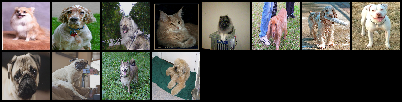

In [15]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

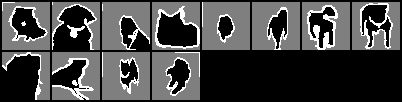

In [16]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

## Loss function (Custom IoU and Custom IoU Loss)
We define a custom IoU metric that is differentiable so that it can be used as a loss functions if needed.

This IoU metric is different from the standard IoU metric that has a hard distinction between predicted classes by the model. In this custom IoU metric, we use the probability of the predicted class (after applying SoftMax) to determine the degree of overlap. In that sense, this isn't a pure IoU metric, but it does help us capture the essense of an IoU metric.

IoU is also sometimes called Jaccard Index or Jaccard similarity metric.

### Why use IoU instead of pixel accuracy?
For segmentation tasks, if you have input images where (say) just 10% of the image has the object you wish to cover with the object segmentation mask, and the rest of the image is supposed to be classified as background, then the pixel accuracy metric may not be the best metric to use.

Here's why. If the model were to predict every pixel as a background pixel, it would trivially achieve 90% accuracy for its prediction!

Hence, for cases where the object and background pixels are unbalanced, an IoU metric may be a better choice.

Here are some links to learn more about metrics for segmentation tasks:

1. https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
2. https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388
3. https://towardsdatascience.com/evaluating-image-segmentation-models-1e9bb89a001b

In [17]:
def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 3, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z
# end def

test_custom_iou_loss()

tensor(1.7432, grad_fn=<NegBackward0>)

### Training functions

In [36]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path,print_every=2):
    os.makedirs(save_path, exist_ok=True)
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        if i%print_every==0:
            with torch.inference_mode():
                # Display the plt in the final training epoch.
                print_test_dataset_masks(model, test_inputs, test_targets, 
                                         epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))

        if scheduler is not None:
            scheduler.step()

## SegNet Basic with standard convolutions

A SegNet model architecture, is well suited for image segmentation tasks, and isn't as memory intensive as U-Net models are. More information about the SegNet model and its architecture can be found here: https://arxiv.org/abs/1511.00561

### Define the model

In [37]:
#controlls the width of the convolutions, which is 2**(width_complexity+depth). The larger the more parameters.
width_complexity=3

In [38]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
m = SegNet(kernel_size=3, width_complexity = width_complexity)
m.eval()
to_device(m)
m(to_device(train_pets_inputs)).shape

torch.Size([12, 3, 48, 48])

In [39]:
print_model_parameters(m)

The Model has 0.24M parameters


### Train the model

In [40]:
n_epochs=5

In [41]:
working_dir = '../meta_data/segnet/'#where to store figures
model_save_path = '../models/segnet/'#where we store models

In [42]:
# Optimizer and Learning Rate Scheduler.
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.9867
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7673
Epoch: 02, Accuracy[Pixel: 0.7228, IoU: 0.4077, Custom IoU: 0.4151]
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7143
Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6778
Epoch: 04, Accuracy[Pixel: 0.7465, IoU: 0.4690, Custom IoU: 0.4579]


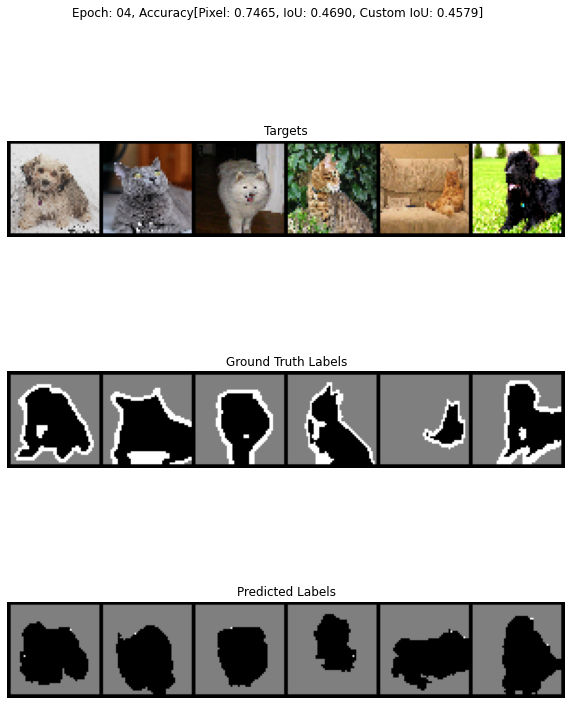

In [43]:
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, n_epochs), 
                           optimizer, scheduler, save_path)

In [26]:
# Save the model's checkpoint.
os.makedirs(model_save_path, exist_ok=True)
save_model_checkpoint(m,model_save_path,f"pets_segnet_CrossEntropyLoss_LRSchedule_"+str(n_epochs)+"_epochs.pth")

## SegNet Basic with depthwise-separable convolutions
We use depthwise separable convolutions to reduce the model's size (number of trainable parameters).

Depthwise Separable convolutions were first introduced by L. Sifre. Rigid-motion scattering for image classiﬁcation, 2014. in their Ph.D. thesis.

Depthwise separable convolutions were made popular by Mobilenet. You can read more about them here: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

### Define the model

In [27]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
mdsc = SegNetDSC(kernel_size=3,width_complexity = width_complexity)
mdsc.eval()
to_device(mdsc)
mdsc(to_device(train_pets_inputs)).shape

torch.Size([12, 3, 48, 48])

In [28]:
print_model_parameters(mdsc)

The Model has 0.03M parameters


### Train the model

In [30]:
to_device(mdsc)
optimizer2 = torch.optim.Adam(mdsc.parameters(), lr=0.001)
scheduler2 = None

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.0131
Epoch: 01, Accuracy[Pixel: 0.5041, IoU: 0.4874, Custom IoU: 0.2555]
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8108
Epoch: 02, Accuracy[Pixel: 0.6553, IoU: 0.3751, Custom IoU: 0.3525]
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7290
Epoch: 03, Accuracy[Pixel: 0.7315, IoU: 0.4902, Custom IoU: 0.4088]
Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6902
Epoch: 04, Accuracy[Pixel: 0.7570, IoU: 0.4266, Custom IoU: 0.4567]


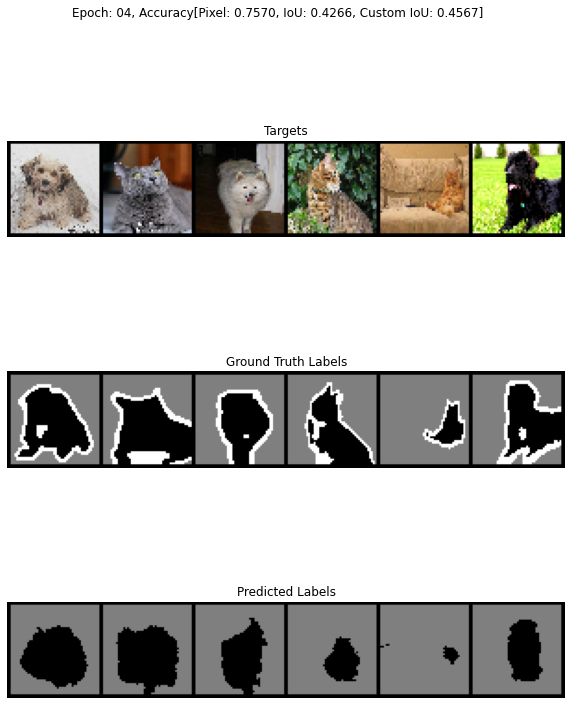

In [31]:
# Train the model that uses depthwise separable convolutions.
save_path2 = os.path.join(working_dir, "segnet_basic_dsc_training_progress_images")
train_loop(mdsc, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, n_epochs), 
           optimizer2, scheduler2, save_path2)

In [32]:
save_model_checkpoint(mdsc,model_save_path, f"pets_segnet_DSC_CrossEntropyLoss_"+str(n_epochs)+"_epochs.pth")

## Validate model accuracy on the complete test dataset
So far, we have been checking the metrics of interest only on a small subset of the test dataset (21 images).

Now, let's try to compute these numbers on the entire test dataset so that we can be sure that the numbers are representative.

In [33]:
# Load both model checkpoints.
load_model_from_checkpoint(m, model_save_path+"/pets_segnet_CrossEntropyLoss_LRSchedule_"+str(n_epochs)+"_epochs.pth")
load_model_from_checkpoint(mdsc, model_save_path+"/pets_segnet_DSC_CrossEntropyLoss_"+str(n_epochs)+"_epochs.pth")

<All keys matched successfully>

In [34]:
# Let's test the accuracy of both models on the test dataset.
with torch.inference_mode():
    test_dataset_accuracy(m, pets_test_loader)
    test_dataset_accuracy(mdsc, pets_test_loader)

The Model has 0.24M parameters
Test Dataset Accuracy
Pixel Accuracy: 0.7240, IoU Accuracy: 0.4322, Custom IoU Accuracy: 0.4258
The Model has 0.03M parameters
Test Dataset Accuracy
Pixel Accuracy: 0.7334, IoU Accuracy: 0.4122, Custom IoU Accuracy: 0.4519


In [35]:
# Clear the PyTorch CUDA cache to free up some memory.
torch.cuda.empty_cache()